<h2>Interactive Experiment</h2>
<font size="3" face="Verdana">
<p style="text-align:justify">Here, you find an implementation of Fitts experiment. </p>
<p style="text-align:justify">To start it, click into the first code-block and press the "Run" button at the top of this page.</p> 
<p>A grey square will appear with two bars, one red and one white. Always click on the red bar as fast as possible. When everything turns green, the experiment is complete. Then you can click in the next code block and again press "Run" to show the results.</p>
</font>

In [2]:
from ipycanvas import Canvas
import numpy as np
import math
from ipywidgets import Label, HTML, HBox, Image, VBox, Box, HBox
from ipyevents import Event
from IPython.display import display
from datetime import datetime
import matplotlib.pyplot as plt


global_width = 800
global_height = 500

canvas = Canvas(width=global_width, height=global_height)

canvas.fill_style = 'gray'
canvas.fill_rect(0, 0, global_width, global_height)




def positionBars(IndxRed, distance, width):
    canvas.fill_style = 'gray'
    canvas.fill_rect(0, 0, global_width, global_height)
    if IndxRed == 0:
        canvas.fill_style = 'red'
        canvas.fill_rect((global_width/2)-(distance/2)-(width/2),0, width, global_height)
        canvas.fill_style = 'snow'
        canvas.fill_rect((global_width/2)+(distance/2)-(width/2),0, width, global_height)
    else:
        canvas.fill_style = 'snow'
        canvas.fill_rect((global_width/2)-(distance/2)-(width/2),0, width, global_height)
        canvas.fill_style = 'red'
        canvas.fill_rect((global_width/2)+(distance/2)-(width/2),0, width, global_height)

            
def isClickInPoint(x, distance, width, IndxRed):
    if IndxRed == 0:
        distanceToBarCenter = abs(x - ((global_width/2)-(distance/2)))
    else:
        distanceToBarCenter = abs(x - ((global_width/2)+(distance/2)))
    if distanceToBarCenter <= width/2:
        return True
    else:
        return False
    

    
def handle_mouse_down(x, y):
    global distance
    global width
    global IndxRed
    global indxRepeat
    global distanceArray
    global indxDist
    global widthArray
    global indxWidth
    global global_width
    global global_height
    global end
    global d_length
    global w_length
    global numRepeat

    if end:
        return False
    
    #check if point was hit
    if isClickInPoint(x, distanceArray[indxDist], widthArray[indxWidth], IndxRed):
        #timestamp
        timestamps[indxDist, indxWidth, indxRepeat] = datetime.utcnow().timestamp()
        
        indxRepeat += 1
        #change conditions
        if indxRepeat == numRepeat:
            indxRepeat = 0
            indxWidth += 1
            if indxWidth == w_length:
                indxWidth = 0
                indxDist += 1
                if indxDist == d_length:
                    canvas.fill_style = 'green'
                    canvas.fill_rect(0,0, global_width, global_height)
                    end = True
        #if point was hit, go to next point
        IndxRed += 1
        IndxRed = IndxRed % 2
        positionBars(IndxRed, distanceArray[indxDist], widthArray[indxWidth])
    
    pass

canvas.on_mouse_down(handle_mouse_down)


#initialize
distanceArray = [140, 280, 560]
widthArray = [15, 30, 60, 120]
d_length = len(distanceArray)
w_length = len(widthArray)
indxDist = 0
indxWidth = 0
indxRepeat = 0
numRepeat = 10
timestamps = np.zeros((d_length,w_length,numRepeat))
end = False

width = widthArray[indxWidth]
distance = distanceArray[indxDist]
IndxRed = 0
positionBars(IndxRed, distance, width)



canvas

Canvas(width=800)

In [3]:
#compute differences between two clicks
deltaTimes = np.zeros((d_length,w_length,numRepeat-1))
for i in range(d_length):
    for j in range(w_length):
        for t in range(numRepeat-1):
            deltaTimes[i,j,t] = timestamps[i,j,t+1] - timestamps[i,j,t]


#compute average time between two clicks for each condition
averageDeltaTimes = np.zeros((d_length,w_length))
for i in range(d_length):
    for j in range(w_length):
        sum = 0.0
        for t in range(numRepeat-1):
            sum += deltaTimes[i,j,t]
        averageDeltaTimes[i,j] = round(sum/(numRepeat-1),4)
        
        
#compute index of difficulty for each condition
indxOfDifficulty = np.zeros((d_length*w_length))
for i in range(d_length):
    for j in range(w_length):
        indxOfDifficulty[i*w_length+j] = round(np.log2(2*distanceArray[i] / widthArray[j]),4)
        
        
#compute index of performance for each condition
indxOfPerformance = np.zeros((d_length*w_length))
for i in range(d_length):
    for j in range(w_length):
        indxOfPerformance[i*w_length+j] = round(indxOfDifficulty[i*w_length+j]/averageDeltaTimes[i][j],4)


print("RESULT")
print("Distance in pixel | Width in pixel | Time in seconds | Index of Difficulty | Index of Performance ")
for i in range(d_length):
    for j in range(w_length): 
        print(distanceArray[i], "               ", widthArray[j], "             ", averageDeltaTimes[i,j], "          ", indxOfDifficulty[i*w_length+j], "              ", indxOfPerformance[i*w_length+j])


        

times = averageDeltaTimes.flatten()

#compute linear regression
IDmatrix = np.ones((len(indxOfDifficulty), 2))
IDmatrix[:,1] = indxOfDifficulty
ABmatrix = np.linalg.pinv(IDmatrix).dot(times)

xLine = np.arange(1, 8, 1)

#Plot Experiment result with linear regression
plt.plot(indxOfDifficulty, times, 'bo', xLine, ABmatrix[0]+ABmatrix[1]*xLine, 'r')
plt.xlabel('Index of Difficulty')
plt.ylabel('Time')
plt.show()

print("Device specific constants:")
print("a: ", ABmatrix[0])
print("b: ", ABmatrix[1])

RESULT
Distance in pixel | Width in pixel | Time in seconds | Index of Difficulty | Index of Performance 
140                 15               0.6022            4.2224                7.0116
140                 30               0.6475            3.2224                4.9767
140                 60               0.3795            2.2224                5.8561
140                 120               0.2607            1.2224                4.6889
280                 15               0.7372            5.2224                7.0841
280                 30               0.6093            4.2224                6.9299
280                 60               0.5679            3.2224                5.6742
280                 120               0.4218            2.2224                5.2688
560                 15               0.946            6.2224                6.5776
560                 30               0.7019            5.2224                7.4404
560                 60               0.6671          

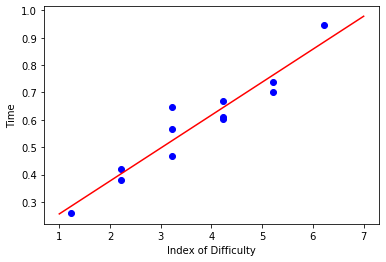

Device specific constants:
a:  0.13618174840579744
b:  0.12032826086956519
